In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model

plt.style.use("dark_background")

In [2]:
df = pd.read_csv("./Datasets/Gemini_ETHUSD_d.csv",  
                 skiprows=1, 
                 parse_dates=True, 
                 index_col='Date')
df = df.sort_index().drop(['Symbol','Unix Timestamp'] , axis=1)
df.head()

Open   High    Low  Close  Volume ETH  Volume USD
Date                                                          
2016-05-09  12.00  12.00   9.36   9.98     1317.90    12885.06
2016-05-10   9.98   9.98   9.36   9.68      672.06     6578.20
2016-05-11   9.68  10.47   9.68  10.43     3052.51    30978.11
2016-05-12  10.43  12.00   9.92  10.20     2072.56    22183.39
2016-05-13  10.20  11.59  10.20  10.69     1769.71    18923.55

# Non-Stationary & LSTM

In [6]:
test_cutoff_date = df.index.max() - timedelta(days=90) # 마지막으로부터 90일치를 test로 쓰고, 나머지는 train

df_test = df[df.index > test_cutoff_date]['Close']
df_train = df[df.index <= test_cutoff_date]['Close']


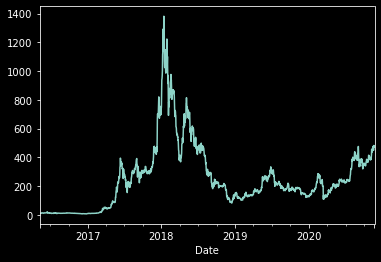

In [11]:
df["Close"].plot.line();

Single Step => 1일치 예측.

## Blocked CV

In [12]:
# CV (교차검증) 데이터를 만드는 과정. 

from numpy import array

# Blocking 방법으로 교차검증 데이터를 만드는 과정.
#                  시계열,     train 시퀀스 길이=30, 예측 값의 길이=1.
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
 #    0              100
 #    1              100
    for i in range(len(sequence)): 
        end_ix = i + n_steps_in # train 시퀀스의 끝 index를 계산.
        out_end_ix = end_ix + n_steps_out # 예측 시퀀스의 끝 index 계산.
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x) # 0,30 / 1,31 / 2,32 ...... 69 / 99
        y.append(seq_y) # 31 / 32 / 33 ..........  100
    return array(X), array(y)

raw_seq = df_train # train seq를 block cv가 가능하도록 쪼갠다.
n_steps_in = 30
n_steps_out = 1

X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [13]:
X.shape

(1537, 30, 1)

In [14]:
y.shape

(1537, 1)

# Modeling

In [17]:
model = Sequential()
model.add(LSTM(128, activation="relu", input_shape=(n_steps_in, n_features), return_sequences=True))
model.add(Dropout(rate=0.5))
model.add(LSTM(units=128, activation="relu", return_sequences=True))
model.add(Dropout(rate=0.5))
model.add(LSTM(units=128, activation="relu", return_sequences=True))
model.add(Dropout(rate=0.5))
model.add(LSTM(units=128, activation="relu")) # Many to One
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)              

In [21]:
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [22]:
hist = model.fit(X, y, epochs=100, batch_size=64)

Epoch 1/100
25/25 [==============================] - 12s 231ms/step - loss: 79882.5781
Epoch 2/100
25/25 [==============================] - 6s 245ms/step - loss: 50005.6055
Epoch 3/100
25/25 [==============================] - 6s 248ms/step - loss: 826072.2500
Epoch 4/100
25/25 [==============================] - 5s 214ms/step - loss: 18041582.0000
Epoch 5/100
25/25 [==============================] - 5s 200ms/step - loss: 64487328.0000
Epoch 6/100
25/25 [==============================] - 5s 211ms/step - loss: 88853992.0000
Epoch 7/100
25/25 [==============================] - 4s 176ms/step - loss: 79186832.0000
Epoch 8/100
25/25 [==============================] - 5s 209ms/step - loss: 53647232.0000
Epoch 9/100
25/25 [==============================] - 5s 216ms/step - loss: 424401408.0000
Epoch 10/100
25/25 [==============================] - 6s 230ms/step - loss: 135242512.0000 3s - 
Epoch 11/100
25/25 [==============================] - 6s 233ms/step - loss: 60956524.0000
Epoch 12/100
25/25

In [23]:
# train을 그대로 다시 예측.
train_pred = model.predict(X)

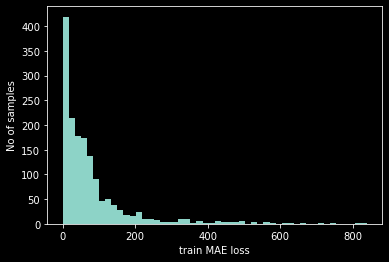

In [24]:
train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

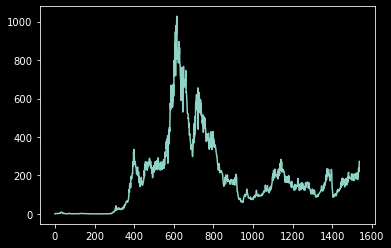

In [25]:
plt.plot(train_pred)

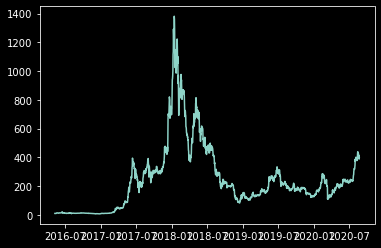

In [26]:
plt.plot(df_train)

In [27]:
train_df_with_pred = df_train.to_frame()[n_steps_in:]
train_df_with_pred['pred'] = train_pred

<AxesSubplot:xlabel='Date'>

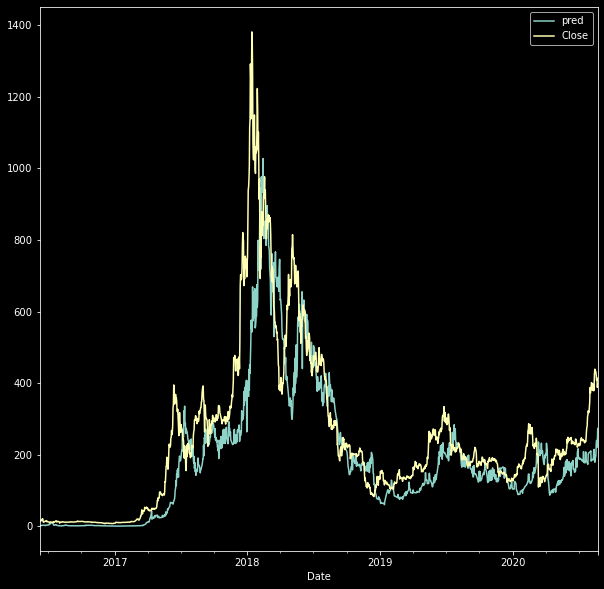

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
train_df_with_pred['pred'].plot(ax=ax, legend=True)
train_df_with_pred['Close'].plot(ax=ax, legend=True)

In [29]:
test_raw_seq = df_test

test_X, test_y = split_sequence(test_raw_seq, n_steps_in, n_steps_out)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [30]:
y_pred = model.predict(test_X)

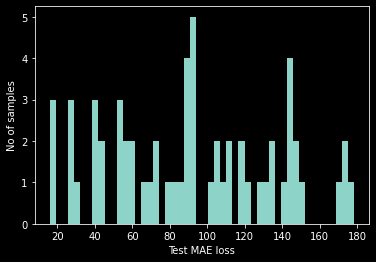

In [31]:
test_mae_loss = np.mean(np.abs(y_pred - test_y), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [32]:
test_df_with_pred = df_test.to_frame()[n_steps_in:]
test_df_with_pred['pred'] = y_pred

<AxesSubplot:xlabel='Date'>

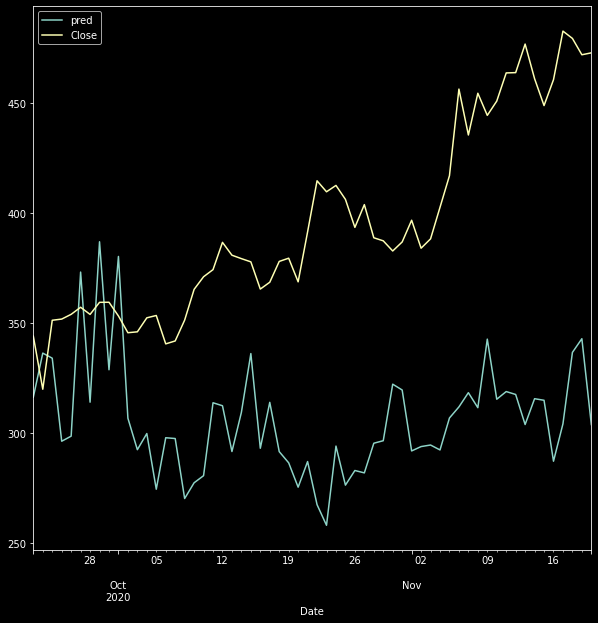

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
test_df_with_pred['pred'].plot(ax=ax, legend=True)
test_df_with_pred['Close'].plot(ax=ax, legend=True)

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# ?

In [ ]:
raw_seq = df_train

n_steps_in, n_steps_out = 60, 7
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
y

array([[ 11.57,  11.09,  11.13, ...,  10.87,  10.76,  11.52],
       [ 11.09,  11.13,  10.83, ...,  10.76,  11.52,  12.2 ],
       [ 11.13,  10.83,  10.87, ...,  11.52,  12.2 ,  10.2 ],
       ...,
       [438.94, 433.18, 434.  , ..., 422.3 , 407.55, 414.53],
       [433.18, 434.  , 430.74, ..., 407.55, 414.53, 388.07],
       [434.  , 430.74, 422.3 , ..., 414.53, 388.07, 395.98]])

In [ ]:
model = Sequential()
model.add(LSTM(128, activation='relu', 
              #  return_sequences=True, 
               input_shape=(n_steps_in, n_features)))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu'))
# 출력 시계열의 특징이 있다면, 모델링 하는 코드가 들어가야 함.
# 없으면 그냥 쓰면 됨.
model.add(Dense(n_steps_out)) # 7
model.compile(optimizer='adam', loss='mae')

In [ ]:
hist = model.fit(X, y, epochs=10, batch_size=64)

Epoch 1/10
24/24 [==============================] - 4s 94ms/step - loss: 227.5251
Epoch 2/10
24/24 [==============================] - 2s 93ms/step - loss: 209.6204
Epoch 3/10
24/24 [==============================] - 2s 92ms/step - loss: 937.7619
Epoch 4/10
24/24 [==============================] - 2s 93ms/step - loss: 1556.0312
Epoch 5/10
24/24 [==============================] - 2s 93ms/step - loss: 852.3376
Epoch 6/10
24/24 [==============================] - 2s 93ms/step - loss: 648.1639
Epoch 7/10
24/24 [==============================] - 2s 94ms/step - loss: 433.4799
Epoch 8/10
24/24 [==============================] - 2s 93ms/step - loss: 351.0766
Epoch 9/10
24/24 [==============================] - 2s 93ms/step - loss: nan
Epoch 10/10
24/24 [==============================] - 2s 90ms/step - loss: nan


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: ignored

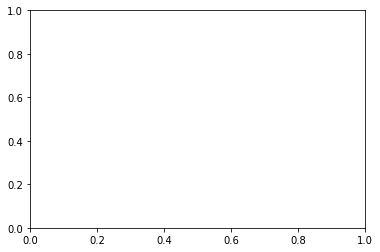

In [ ]:
train_pred = model.predict(X)

train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

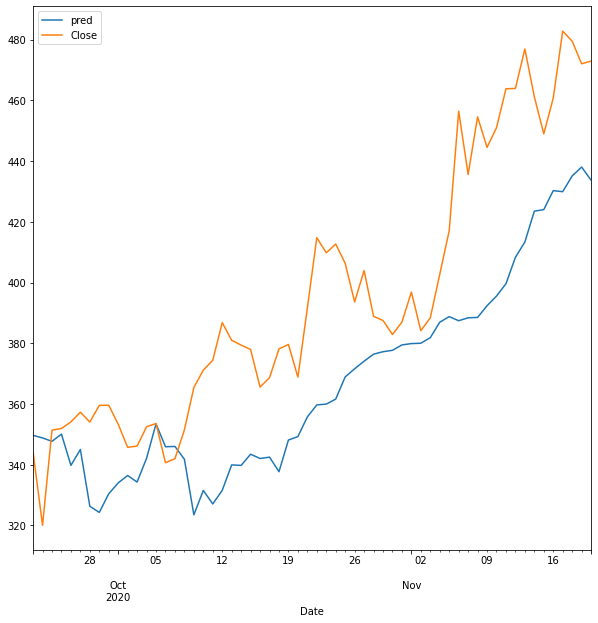

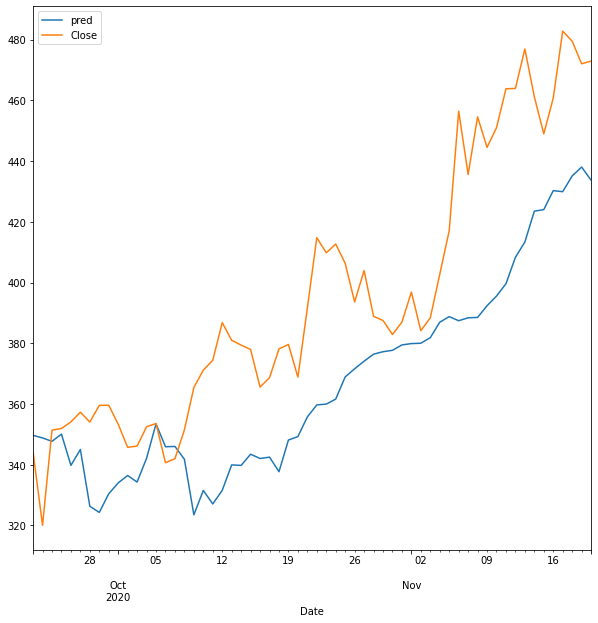

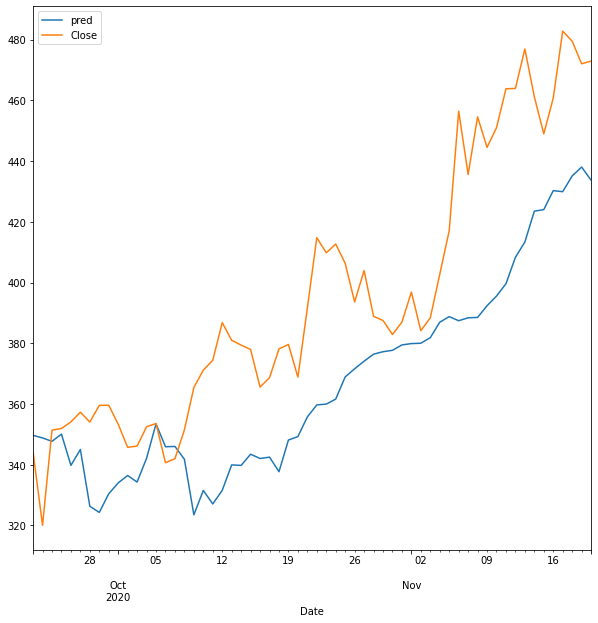

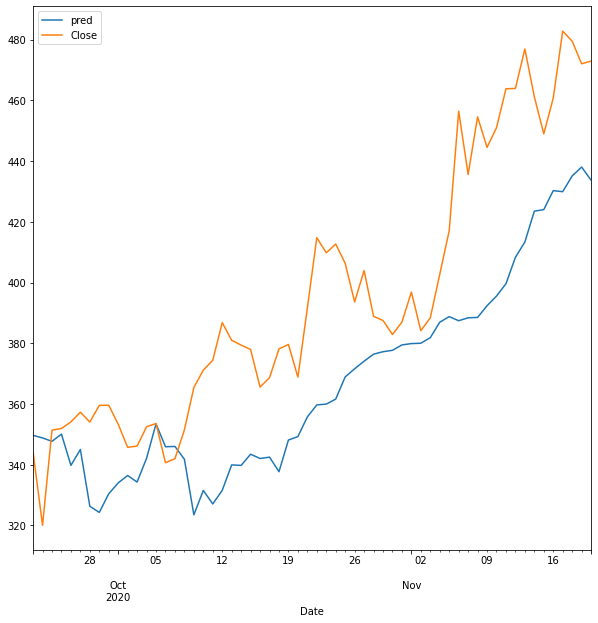

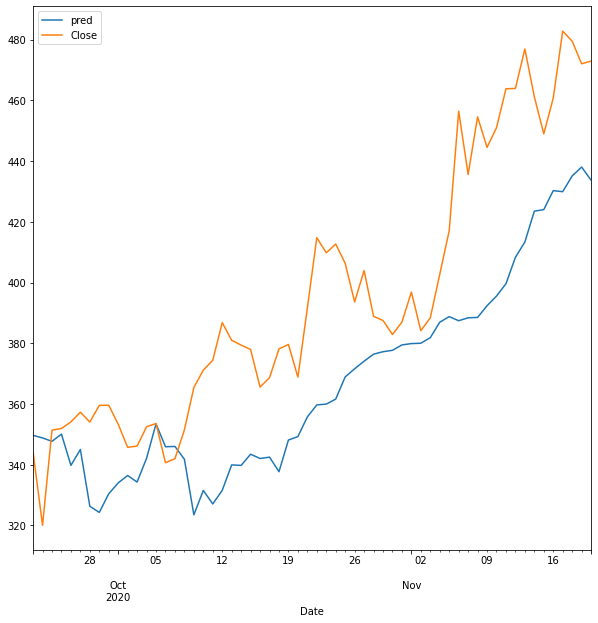

In [ ]:
for i, pred in enumerate(train_pred[:5]):
  train_df_with_pred = df_train[i:i+n_steps_out]
  train_df_with_pred['pred'] = pred
  
  fig, ax = plt.subplots(figsize=(10,10))
  test_df_with_pred['pred'].plot(ax=ax, legend=True)
  test_df_with_pred['Close'].plot(ax=ax, legend=True)
  plt.show()